## Gridded Data Renderer

PAVICS uses ncWMS2 to render netCDF data on a map canvas. ncWMS2 use the OGC's WMS standard to serve images rendered from a netCDF file. The WMS `GetMap` operation specifies a layer (<netCDF file path>/<variable name>), styles, figure size and format, projection and color range and the server returns an image that can be displayed in a figure or a map canvas. 
   
   
Note that with the current configuration, the path for ncWMS layers starts with `outputs` and not `birdhouse` as in the THREDDS server. Note also that the image we obtain below has the North down. 

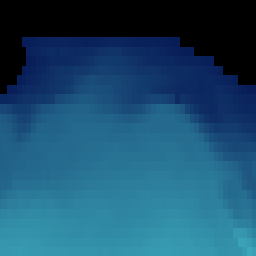

In [1]:
from owslib.wms import WebMapService
from IPython.display import Image

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/ncWMS2/wms"
wms = WebMapService(url, version='1.3.0')
link = 'outputs/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc'
resp = wms.getmap(
          layers=["{}/{}".format(link, "tasmax")], 
          format='image/png', 
          colorscalerange='{},{}'.format(250, 350), 
          size=[256,256], 
          srs='CRS:84', 
          bbox=(150, 30, 250, 80),
          time='2006-02',
          transparent=True)
Image(resp.read())

One issue with the figure above is the colorscale range and the colormap, which do not provide a lot of contrast. In PAVICS, the data crawler while parsing the netCDF metadata also computes the min and max, so that the frontend knows for a given file the data range and can include it in its WMS request. Here, we'll do the same using the OPeNDAP protocol. 

In [2]:
import xarray as xr
dap = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/'
ncfile = 'birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r1i1p1_200601-200612.nc'
ds = xr.open_dataset(dap+ncfile)
subtas = ds.tasmax.sel(time=slice('2006-02-01', '2006-03-01'), lon=slice(188,330), lat=slice(6, 70))
mn, mx = subtas.min().values.tolist(), subtas.max().values.tolist()
mn, mx

(241.01828002929688, 308.3053894042969)

Now we'll simply pass those min/max to `getmap` with the colorscalerange parameter, and change the palette in the same go using the `styles` parameter. 

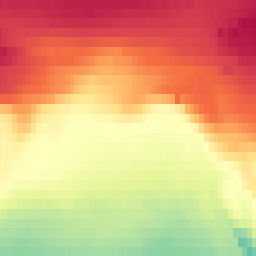

In [3]:
resp = wms.getmap(
          layers=["{}/{}".format(link, "tasmax")], 
          styles=['default/div-Spectral'],
          format='image/png', 
          colorscalerange='{},{}'.format(mn, mx), 
          size=[256,256], 
          srs='CRS:84', 
          bbox=(150, 30, 250, 80),
          time='2006-02',
          transparent=True)
Image(resp.read())